# Simulation 4
See README.md for a short description.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has up to 4 visible files and up to 2 hidden files, and 4 potential vulnerable parameter that may be used against the vulnerable file.

Setting a random seed

In [2]:
np.random.seed(100)

### Random server
We define a simple function to instantiate random servers.

In [3]:
from networkx.generators.classic import complete_graph

def random_server():
    n_visiblefiles = np.random.randint(2,const.N_VISIBLEFILES+1)
    n_hiddenfiles = np.random.randint(0,const.N_HIDDENFILES+1)
    n_totalfiles = n_visiblefiles+n_hiddenfiles
    
    visiblefilesystem = complete_graph(n_visiblefiles)
    filesystem = visiblefilesystem.copy()
    for h in range(n_hiddenfiles):
        filesystem.add_edge(np.random.choice(n_visiblefiles),n_visiblefiles+h)
        
    vulnfile = np.random.choice(n_totalfiles)
    vulnparam = np.random.choice(const.N_VULNPARAMS)+1
    
    return srv.Server(visiblefilesystem, filesystem, vulnfile, vulnparam)

### Creating the agent and setting the learning options 

In [4]:
agt = agn.Agent()
agt.set_learning_options(exploration=0.2, 
                         learningrate=0.2, 
                         discount=0.9)

## Simulation 4.1

We run a little number of episodes ($10$) just to observe the dynamics of the game.

In [5]:
nepisodes = 10
for _ in range(nepisodes):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()


HACKER: Resetting...
SERVER: Server reset
HACKER: Scanning for visible files...
SERVER: Sending list of visible files: ['index.html', 'submit.js']
HACKER: Sending param 3 to file 0...
SERVER: Access Attempt Failed
HACKER: Shifting focus from target file 0 forward...
SERVER: File focus shift
HACKER: Shifting focus from target file 1 forward...
SERVER: File focus shift
HACKER: Shifting focus from target file 0 forward...
SERVER: File focus shift
HACKER: Sending param 3 to file 1...
SERVER: Access Attempt Failed
HACKER: Shifting focus from target file 1 forward...
SERVER: File focus shift
HACKER: Sending param 1 to file 0...
SERVER: Access Attempt Failed
HACKER: Sending param 4 to file 0...
SERVER: Access Attempt Failed
HACKER: Sending param 2 to file 0...
SERVER: Access Attempt Failed
HACKER: Sending param 1 to file 0...
SERVER: Access Attempt Failed
HACKER: Sending param 1 to file 0...
SERVER: Access Attempt Failed
HACKER: Sending param 1 to file 0...
SERVER: Access Attempt Failed
HACK

## Simulation 4.2
Given the large space of states and actions we train the agent for longer.

**(Notice that this may take some minutes to run)**

**(Notice we reiniatialized the agent not to be verbose)**

In [6]:
agt = agn.Agent(verbose=False)
agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

In [7]:
steps = []
rewards = []
Qlens = []

nepisodes = 10**5
for _ in tqdm(range(nepisodes)):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()
    #print(len(agt.Q.keys()))
    
    steps.append(agt.steps)
    rewards.append(agt.rewards)
    Qlens.append(len(agt.Q))

100%|██████████| 100000/100000 [01:05<00:00, 1517.21it/s]


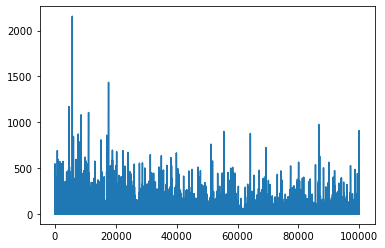

In [8]:
plt.plot(np.arange(nepisodes),steps)

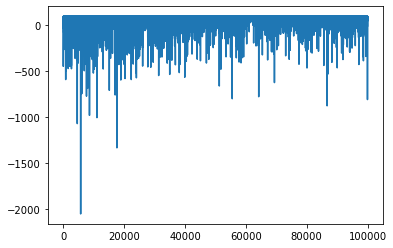

In [9]:
plt.plot(np.arange(nepisodes),rewards)

Learning takes a long time, but we notice indeed that the number of steps decrease while the amount of reward increase.

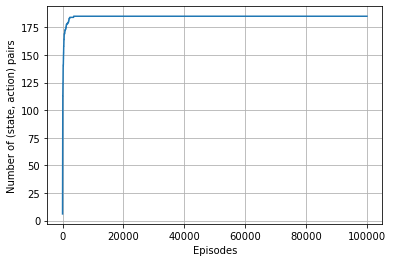

In [10]:
plt.plot(np.arange(nepisodes),Qlens)
plt.xlabel('Episodes')
plt.ylabel('Number of (state, action) pairs')
plt.grid()
plt.savefig('simul4_qlens')

We also observe a constant increase in the size of the Q-table (which grows exponentially at the beginning and slows down later). As new states are encountered during learning and exploration, new states are added to the Q-table. This game setting already shows the limitation of a Q-tabular approach, both in the sense of *space requirements* and in the sense of *lack of generalization*.

To get a better evaluation of our policy we now consider the results obtained by running $100$ more simulations with no exploration.

In [11]:
steps = []
rewards = []

agt.eps = 0.0

nepisodes = 100
for _ in tqdm(range(nepisodes)):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()
    #print(len(agt.Q.keys()))
    
    steps.append(agt.steps)
    rewards.append(agt.rewards)

100%|██████████| 100/100 [00:00<00:00, 1443.19it/s]


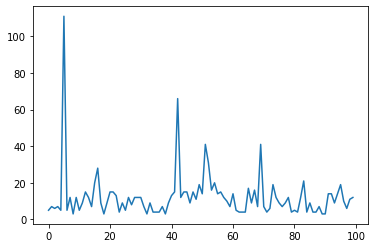

In [12]:
plt.plot(np.arange(nepisodes),steps)

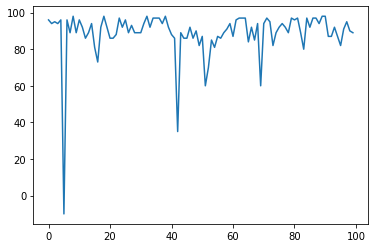

In [13]:
plt.plot(np.arange(nepisodes),rewards)

## Simulation 4.3
We run the previous simulation with the non-exploring agent for $100$ times in order to collect stable statistics. 

**Notice that this agent may get stuck because of its non-exploring policy.**

In [14]:
ntrials = 100
nepisodes = 100

steps = np.zeros((ntrials,nepisodes))
rewards = np.zeros((ntrials,nepisodes))

for t in tqdm(range(ntrials)):
    
    newagt = agt.copy()

    for e in range(nepisodes):
        env = random_server()
        newagt.reset(env)

        newagt.run_episode()

        steps[t,e] = newagt.steps
        rewards[t,e] = newagt.rewards

100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


import joblib
joblib.dump(steps, 'res_steps_100steps_100iter.pkl')
joblib.dump(rewards, 'res_rewards_100steps_100iter.pkl')

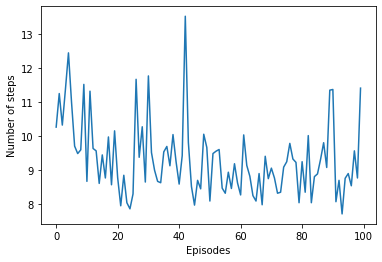

In [15]:
plt.plot(np.arange(nepisodes),np.mean(steps,axis=0))
plt.xlabel('Episodes')
plt.ylabel('Number of steps')
plt.savefig('simul4_steps.png')

Text(0, 0.5, 'Reward')

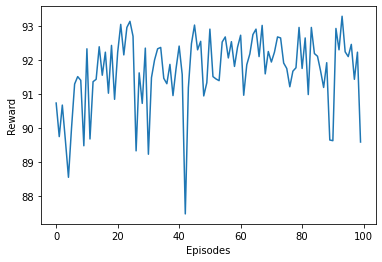

In [16]:
plt.plot(np.arange(nepisodes),np.mean(rewards,axis=0))
plt.xlabel('Episodes')
plt.ylabel('Reward')

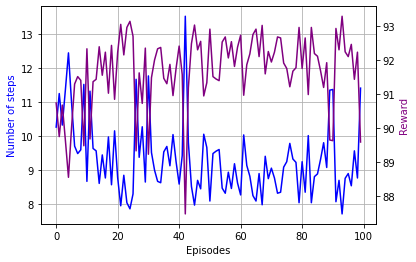

In [17]:
_,ax1 = plt.subplots()
plt.grid()

ax1.plot(np.arange(nepisodes),np.mean(steps,axis=0), c='blue')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Number of steps',c='blue')

ax2 = ax1.twinx()
ax2.plot(np.arange(nepisodes),np.mean(rewards,axis=0),c='purple')
ax2.set_ylabel('Reward',c='purple')

plt.savefig('simul4_plots')